### COVID-19 Classification with Focal Loss

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"

### Load chest x-ray dataset

In [0]:
data_dir = '/content/A_05_Part_02_Dataset'

In [26]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [27]:
print(train_data.class_to_idx)

{'covid-19': 0, 'normal': 1, 'pneumonia': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


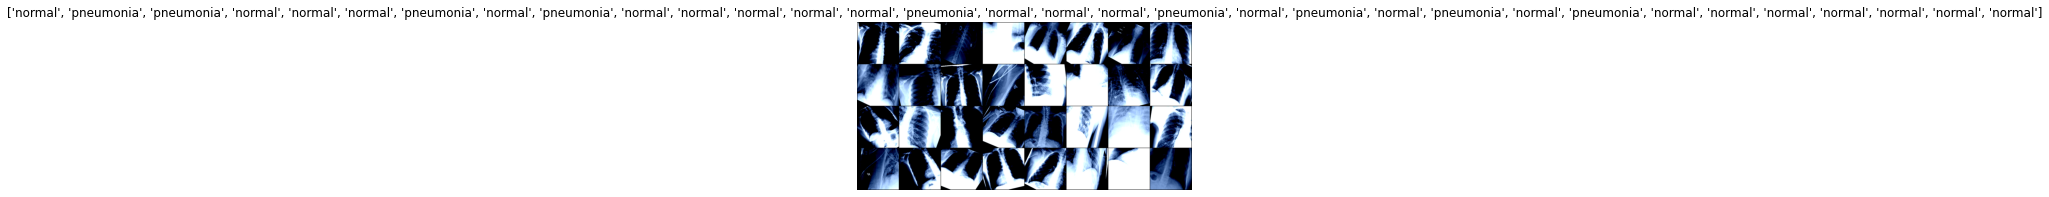

In [28]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Compute loss and accuracy

In [0]:
def get_encoded_labels_for_class(label):
  if label == 0:
      # COVID-19 Class
    one_hot_encoded_labels = [1, 0, 1]
  elif label == 1:
    # Normal Class
    one_hot_encoded_labels = [0, 1, 0]
  else:
    # Pneumonia Class
    one_hot_encoded_labels = [0, 0, 1]
  return one_hot_encoded_labels

def get_class_for_encoded_labels(label):
  if label == [1, 0, 1]:
    return 0
  elif label == [0, 1, 0]:
    return 1
  elif label == [0, 0, 1]:
    return 2
  return -1

In [0]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
def compute_loss_and_accuracy(loader, model):
  loss = 0
  correct_labels = []
  predicted_labels = []
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
  
          outputs = model(images)

          predicted = []
          for predicted_output in outputs.data:
            predicted_output = torch.sigmoid(predicted_output)
            thresholded_vector = (predicted_output >= 0.5).int()
            # predicted.append(get_class_for_encoded_labels(thresholded_vector))
            predicted.append(thresholded_vector.tolist())

          predicted_labels.extend(predicted)

          one_hot_encoded_labels = []
          for label in labels:
            one_hot_encoded_labels.append(get_encoded_labels_for_class(label))

          correct_labels.extend(one_hot_encoded_labels)

          one_hot_encoded_labels = torch.FloatTensor(one_hot_encoded_labels)
          one_hot_encoded_labels = one_hot_encoded_labels.to(device)

          loss += criterion(outputs, one_hot_encoded_labels).item()

  conf_matrix = multilabel_confusion_matrix(correct_labels, predicted_labels)
  f1 = f1_score(correct_labels, predicted_labels, average='weighted')
  return loss, conf_matrix, f1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Function to plot confusion matrix using seaborn (https://github.com/DTrimarchi10/confusion_matrix)

In [0]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')
  
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Training function

In [0]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn

def train_model(model, Epochs, criterion, optimizer, output_file, loss_item=True):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()

    loss_per_iter_train = []
    f1_per_iter_train = []

    loss_per_iter_validation = []
    f1_per_iter_validation = []

    epochs = range(Epochs)
    for epoch in epochs:  # loop over the dataset multiple times

        running_loss = 0.0
        pbar = tqdm(enumerate(trainloader))

        correct_labels = []
        predicted_labels = []

        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            one_hot_encoded_labels = []
            for label in labels:
              one_hot_encoded_labels.append(get_encoded_labels_for_class(label))

            correct_labels.extend(one_hot_encoded_labels)

            one_hot_encoded_labels = torch.FloatTensor(one_hot_encoded_labels)
            one_hot_encoded_labels = one_hot_encoded_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, one_hot_encoded_labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

            predicted = []
            for predicted_output in outputs.data:
              thresholded_vector = (predicted_output >= 0.5).int()
              predicted.append(thresholded_vector.tolist())

            predicted_labels.extend(predicted)
            
            if loss_item:
              loss = loss.item()
  
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss))
            
        loss_per_iter_train.append(running_loss)
        f1 = sklearn.metrics.f1_score(correct_labels, predicted_labels, average='weighted')
        f1_per_iter_train.append(f1)

        print('Train F1 score: {} %'.format(f1))

        validation_loss, conf_matrix, validation_f1 = compute_loss_and_accuracy(validationloader, model)
        loss_per_iter_validation.append(validation_loss)
        f1_per_iter_validation.append(validation_f1)

        print('Validation F1 score: {} %'.format(validation_f1))


    plt.grid()
    plt.plot(epochs, f1_per_iter_validation, 'o-', color="r",
                  label="F1 score per iteration validation")
    plt.plot(epochs, f1_per_iter_train, 'o-', color="g",
                  label="F1 score per iteration train")
    plt.legend(loc="best")
    plt.show()

    plt.grid()
    plt.plot(epochs, loss_per_iter_validation, 'o-', color="r",
                  label="Loss per iteration validation")
    plt.plot(epochs, loss_per_iter_train, 'o-', color="g",
                  label="Loss per iteration train")
    plt.legend(loc="best")
    plt.show()

    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Zero', 'One']

    train_loss, conf_matrix,  f1_score = compute_loss_and_accuracy(trainloader, model)
    print('Train F1 Score: ', f1_score)
    print('Training Confusion Matrices')
    make_confusion_matrix(conf_matrix[0], group_names=labels, categories=categories, title='COVID-19 (Training)')
    make_confusion_matrix(conf_matrix[1], group_names=labels, categories=categories, title='Normal (Training)')
    make_confusion_matrix(conf_matrix[2], group_names=labels, categories=categories, title='Pneumonia (Training)')

    validation_loss,  conf_matrix, f1_score = compute_loss_and_accuracy(validationloader, model)
    print('Validation F1 Score: ', f1_score)
    print('Validation Confusion Matrices')
    make_confusion_matrix(conf_matrix[0], group_names=labels, categories=categories, title='COVID-19 (Validation)')
    make_confusion_matrix(conf_matrix[1], group_names=labels, categories=categories, title='Normal (Validation)')
    make_confusion_matrix(conf_matrix[2], group_names=labels, categories=categories, title='Pneumonia (Validation)')

    torch.save(model.state_dict(), output_file)
    print('Finished Training')

## Task 1 (without focal loss)

### VGG


Train F1 score: 0.7056281964890455 %
Validation F1 score: 0.8575244447051136 %



Train F1 score: 0.8294051476103855 %
Validation F1 score: 0.8811295411905168 %



Train F1 score: 0.8489812921341734 %
Validation F1 score: 0.8821212652528703 %



Train F1 score: 0.865863139793266 %
Validation F1 score: 0.8829890131838471 %


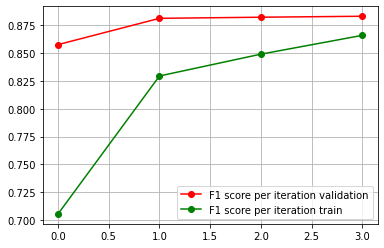

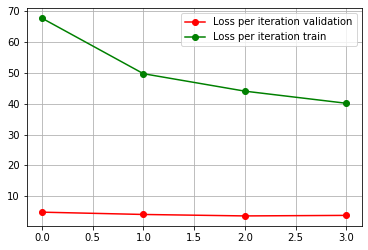

Train F1 Score:  0.8812765696794759
Training Confusion Matrices
Validation F1 Score:  0.8872358721541388
Validation Confusion Matrices
Finished Training


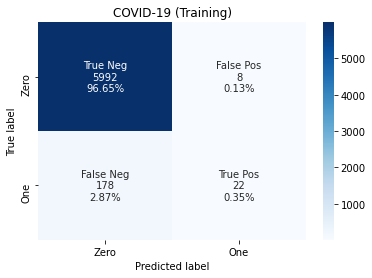

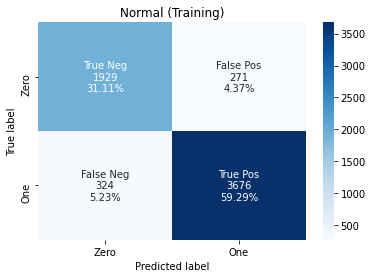

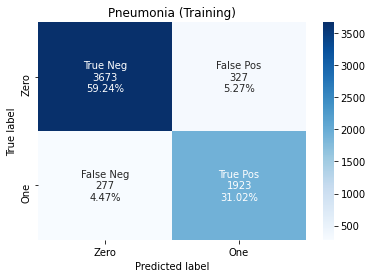

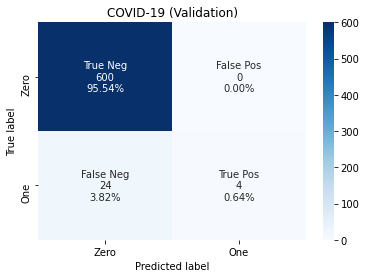

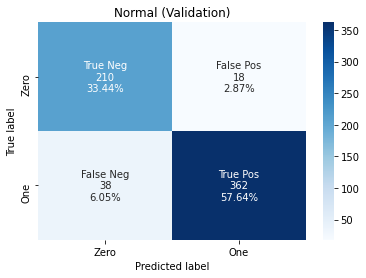

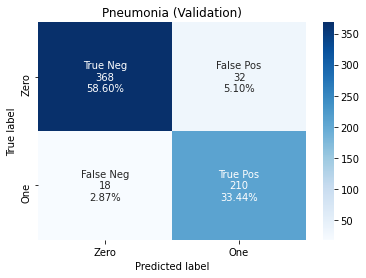

In [108]:
vgg16_task1 = models.vgg16(pretrained=True)

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task1.classifier = nn.Sequential(*features)

output_file='vgg16task1.pth'

Epochs = 4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16_task1.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task1, Epochs, criterion,  optimizer, output_file)

In [0]:
!cp "/content/vgg16task1.pth" "./gdrive/My Drive/Colab Notebooks/a2_vgg16_task1.pth"

### RESNET-18


Train F1 score: 0.5089631137665571 %
Validation F1 score: 0.7969568799607541 %



Train F1 score: 0.7887610246552308 %
Validation F1 score: 0.8416369479973348 %



Train F1 score: 0.8406605765524401 %
Validation F1 score: 0.8710340467627076 %



Train F1 score: 0.8512186065683598 %
Validation F1 score: 0.8767917624013604 %


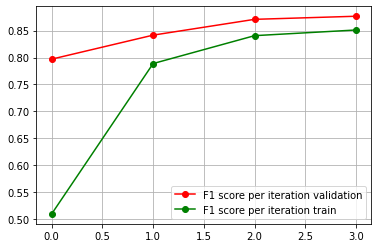

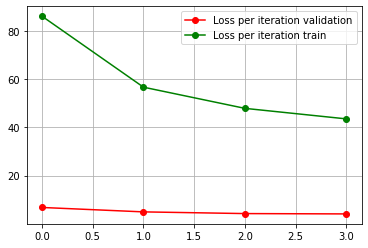

Train F1 Score:  0.864199887431072
Training Confusion Matrices
Validation F1 Score:  0.8777903136474595
Validation Confusion Matrices
Finished Training


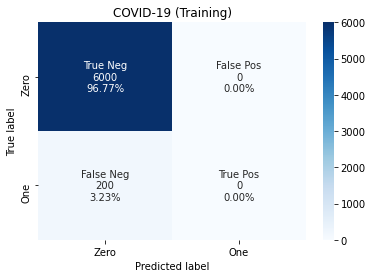

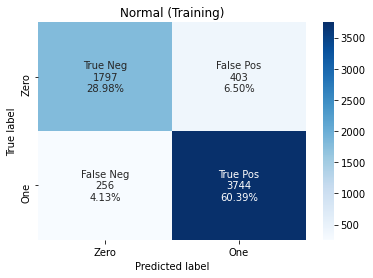

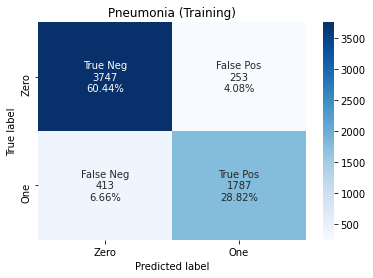

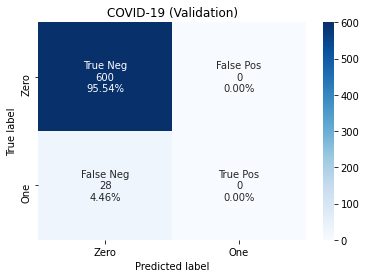

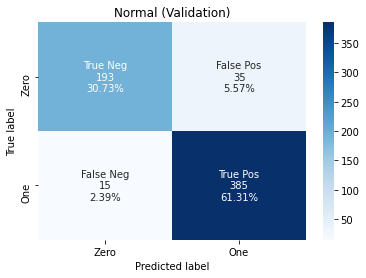

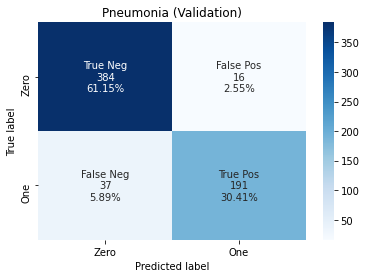

In [110]:
resnet18_task1 = models.resnet18(pretrained=True)
'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task1.fc = nn.Sequential(*features)

output_file='resnet18task1.pth'

Epochs = 4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18_task1.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task1, Epochs, criterion,  optimizer, output_file)


In [0]:
!cp "/content/resnet18task1.pth" "./gdrive/My Drive/Colab Notebooks/a2_res18_task1.pth"

## Task 2 (with focal loss)

In [0]:
gamma = 2
alpha = 0.5
def focal_loss(output, one_hot_encoded_vector):
    # Focal loss as defined in the paper: FL(p_t) = −(1 − p_t)^γ log(p_t).
    # Here, log(p_t) is actually the cross entropy before normalization (i.e. bce loss)
    # and p_t can be computed as e^log(p_t) => p_t
    cross_entropy = torch.nn.functional.binary_cross_entropy_with_logits(
        output,
        one_hot_encoded_vector,
        reduce=False
    )
    p_t = torch.exp(-cross_entropy)
    F_loss = torch.mean(
        alpha * (1 - p_t)**gamma * cross_entropy
    )
    return F_loss

### VGG

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Train F1 score: 0.398201805616183 %
Validation F1 score: 0.8202725585333291 %



Train F1 score: 0.668793895764586 %
Validation F1 score: 0.8422808034219462 %



Train F1 score: 0.7456993829015122 %
Validation F1 score: 0.8755869672075024 %



Train F1 score: 0.7746977139138039 %
Validation F1 score: 0.8751525519393019 %



Train F1 score: 0.7896892705436435 %
Validation F1 score: 0.8823198999253131 %



Train F1 score: 0.7979331568367988 %
Validation F1 score: 0.883997679040952 %



Train F1 score: 0.809699730094467 %
Validation F1 score: 0.8927504514199758 %



Train F1 score: 0.8219613723622285 %
Validation F1 score: 0.8958467963815832 %



Train F1 score: 0.8200967665827403 %
Validation F1 score: 0.8855283359243916 %



Train F1 score: 0.8245994484282356 %
Validation F1 score: 0.8999347204586706 %


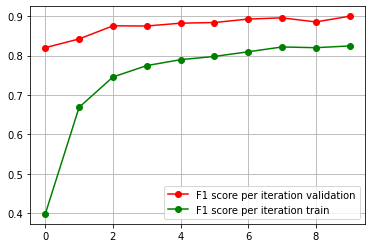

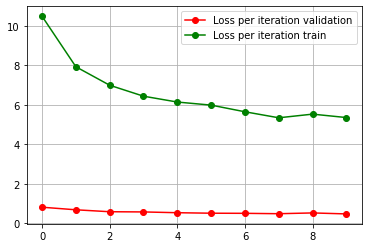

Train F1 Score:  0.8774609124714767
Training Confusion Matrices
Validation F1 Score:  0.8984134214371492
Validation Confusion Matrices
Finished Training


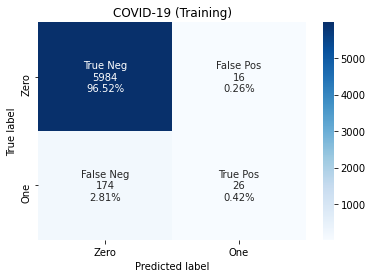

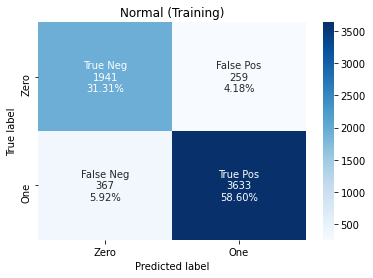

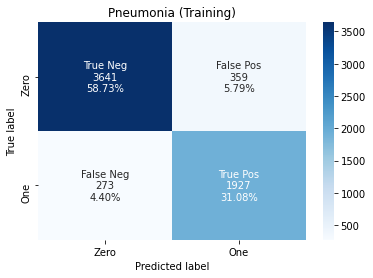

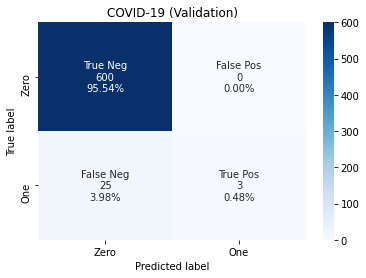

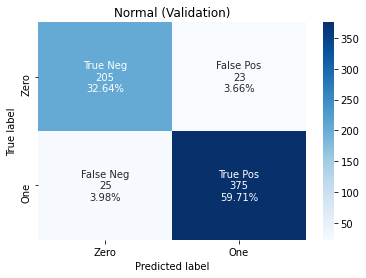

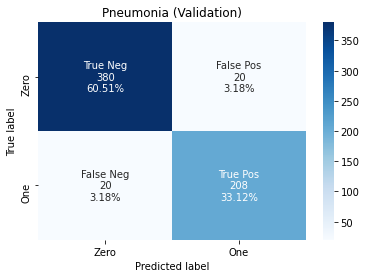

In [126]:
vgg16_task2 = models.vgg16(pretrained=True)

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task2.classifier = nn.Sequential(*features)

output_file='vgg16task2.pth'

Epochs = 10
criterion =  focal_loss
optimizer = optim.SGD(vgg16_task2.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task2, Epochs, criterion, optimizer, output_file, loss_item=False)

In [0]:
!cp "/content/vgg16task2.pth" "./gdrive/My Drive/Colab Notebooks/a2_vgg16_task2_best.pth"

### RESNET-18

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Train F1 score: 0.24199396391513697 %
Validation F1 score: 0.6315849042922771 %



Train F1 score: 0.3431748472847228 %
Validation F1 score: 0.7340995349476931 %



Train F1 score: 0.4421166604153969 %
Validation F1 score: 0.8019896387238284 %



Train F1 score: 0.5566648799313895 %
Validation F1 score: 0.8087679201389931 %



Train F1 score: 0.633676131983357 %
Validation F1 score: 0.8258273585432732 %



Train F1 score: 0.6722497479170346 %
Validation F1 score: 0.8352967640883795 %



Train F1 score: 0.7184868677329409 %
Validation F1 score: 0.8376702730975275 %



Train F1 score: 0.7283473139678884 %
Validation F1 score: 0.8329050595310759 %



Train F1 score: 0.747317562172216 %
Validation F1 score: 0.8532532459652954 %



Train F1 score: 0.758204315065759 %
Validation F1 score: 0.8494885638865325 %


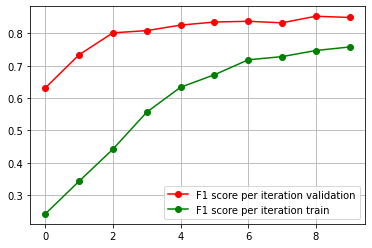

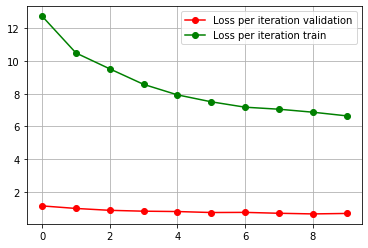

Train F1 Score:  0.8468142247534277
Training Confusion Matrices
Validation F1 Score:  0.8604052784246436
Validation Confusion Matrices
Finished Training


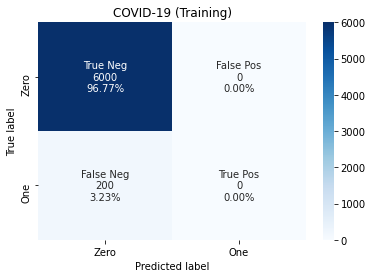

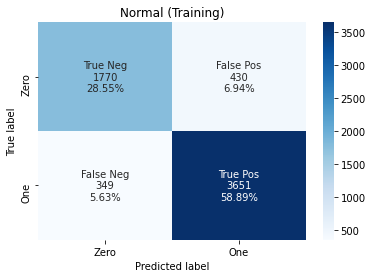

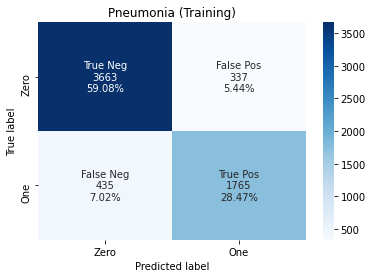

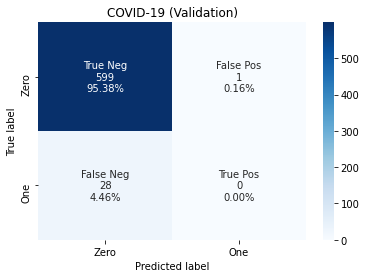

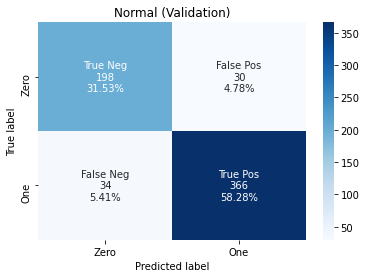

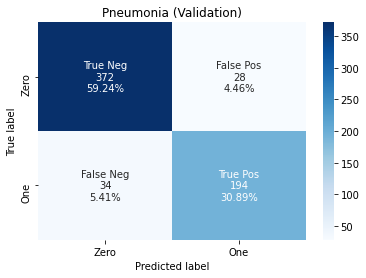

In [139]:
resnet18_task2 = models.resnet18(pretrained=True)

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task2.fc = nn.Sequential(*features)

output_file='resnet18_task2.pth'

Epochs = 10
criterion =  focal_loss
optimizer = optim.SGD(resnet18_task2.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task2, Epochs, criterion,  optimizer, output_file)


In [0]:
!cp "/content/resnet18_task2.pth" "./gdrive/My Drive/Colab Notebooks/a2_res18_task2_best.pth"

In [0]:
!mkdir "/content/test_data"

In [0]:
!cp -r "/content/A_05_Part_02_Dataset/Test" "/content/test_data"

In [0]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

## Image Folder with Paths . Acknowledgment: Andrew Jong https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_data = ImageFolderWithPaths('/content/test_data', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

### Predict labels for test data

In [137]:
import os
results = []
with torch.no_grad():
    predicted_labels = []
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_task2(images)

        for predicted_output, path in zip(outputs.data, paths):
          predicted = []
          predicted.append(os.path.basename(path))
  
          predicted_output = torch.sigmoid(predicted_output)
          thresholded_vector = (predicted_output >= 0.5).int()

          thresholded_vector = thresholded_vector.tolist()
          
          # the order in which hidden results are present
          thresholded_vector[1], thresholded_vector[2] = thresholded_vector[2], thresholded_vector[1]
          predicted.extend(thresholded_vector)
          
          predicted_labels.append(predicted)

    print(predicted_labels)
        
          


[['333.png', 0, 0, 1], ['433.png', 0, 0, 1], ['223.png', 0, 1, 0], ['480.png', 0, 1, 0], ['556.png', 0, 0, 1], ['19.png', 0, 1, 0], ['169.png', 0, 0, 1], ['10.png', 0, 0, 1], ['511.png', 0, 0, 1], ['356.png', 0, 1, 0], ['596.png', 0, 0, 1], ['12.png', 0, 0, 1], ['220.png', 0, 0, 1], ['404.png', 0, 0, 1], ['543.png', 0, 0, 1], ['7.png', 0, 0, 1], ['158.png', 0, 0, 1], ['177.png', 0, 0, 1], ['297.png', 0, 0, 1], ['561.png', 0, 1, 0], ['300.png', 0, 0, 1], ['597.png', 0, 1, 0], ['394.png', 0, 0, 1], ['37.png', 0, 1, 1], ['325.png', 0, 1, 0], ['365.png', 0, 0, 1], ['424.png', 0, 0, 1], ['254.png', 0, 1, 0], ['517.png', 0, 0, 1], ['397.png', 0, 0, 1], ['139.png', 0, 0, 1], ['239.png', 0, 1, 0], ['199.png', 0, 1, 0], ['472.png', 0, 1, 0], ['347.png', 0, 0, 1], ['332.png', 0, 0, 1], ['263.png', 0, 1, 0], ['126.png', 0, 0, 1], ['340.png', 0, 0, 1], ['326.png', 0, 0, 1], ['253.png', 0, 0, 0], ['257.png', 0, 0, 1], ['339.png', 0, 0, 1], ['104.jpg', 0, 0, 1], ['195.png', 0, 0, 1], ['101.png', 0, 

### Store the results in a csv

In [0]:
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('msds19003_results.csv')